In [3]:
import sys; sys.path.append('../')

import time

from src.data_loader import load_data

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import warnings
warnings.filterwarnings('ignore')

/home/nicolas/.local/share/virtualenvs/point-cloud-learn-97nGMN1k/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/nicolas/.local/share/virtualenvs/point-cloud-learn-97nGMN1k/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
plt.rcParams["figure.figsize"] = (20,10)

# Try to binarize

In [5]:
clusters, _ = load_data('../data/huge_sample_input_classified.txt')
clusters = clusters[[
   'class_1_mean', 'class_2_mean', 'class_2_sigma', 'class_4_mean',
   'intensity_mean_origin', 'intensity_sigma_origin',
   'intensity_mean_destination', 'intensity_sigma_destination',
   'orientation_mean_origin', 'slope_mean_origin',
   'orientation_mean_destination', 'slope_mean_destination',
   'coplanararity_index_mean_origin',
   'coplanararity_index_mean_destination', 'classification'
]]

In [6]:
#Delete columns with one value
for col in clusters.columns:
    if len(clusters[col].unique()) == 1:
        clusters.drop(col,inplace=True,axis=1)

In [7]:
clusters['classification'] = (
    ((clusters['classification'] != 'Vegetation') & (clusters['classification'] != 'Limit_effect'))
)
len(clusters)

5958

In [8]:
(33 / (5925 +33)) * 100

0.5538771399798591

In [9]:
max_elements_per_class = min(clusters['classification'].value_counts().values)
balanced_clusters = clusters.drop(clusters.index)
for c in clusters['classification'].unique():
    balanced_clusters = pd.concat([
        balanced_clusters,
        clusters[clusters['classification'] == c].sample(max_elements_per_class)
    ])
len(balanced_clusters)

66

In [10]:
train_percentage = 0.8

data = balanced_clusters.replace('None', np.nan).dropna(axis=0)
all_data = clusters.replace('None', np.nan).dropna(axis=0)

X = data.drop('classification', axis=1)
X = (X - X.mean()) / X.std()
y = data['classification']

all_X = all_data.drop('classification', axis=1)
all_X = (all_X - all_X.mean()) / all_X.std()
all_y = all_data['classification']

train_indexes, test_indexes = next(StratifiedShuffleSplit(n_splits=1, train_size=0.8).split(X, y))
X_train, y_train = X.iloc[train_indexes], y.iloc[train_indexes]
X_test, y_test = X.iloc[test_indexes], y.iloc[test_indexes]

#X_val, y_val = X.iloc[test_indexes], y.iloc[test_indexes]
X_all_test, y_all_test = all_X.loc[~all_X.index.isin(X.index)], all_y.loc[~all_X.index.isin(X.index)]

X_all_test = pd.concat([X_all_test, X_test])
y_all_test = pd.concat([y_all_test, y_test])

In [11]:
print(y_test.value_counts(),'\n', y_train.value_counts())

True     7
False    7
Name: classification, dtype: int64 
 True     26
False    26
Name: classification, dtype: int64


In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, RandomForestClassifier, VotingClassifier)
from sklearn.svm import SVC
models = [
    LinearDiscriminantAnalysis, KNeighborsClassifier, RadiusNeighborsClassifier, GaussianNB,
    DecisionTreeClassifier, ExtraTreeClassifier, AdaBoostClassifier, BaggingClassifier,
    ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, SVC
]

In [28]:
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                                f1_score, roc_auc_score, classification_report)

results = {m.__name__: {} for m in models}
all_results = {m.__name__: {} for m in models}
for Model in models:
    t_start = time.time()    
    try:
        model = Model()
        model.fit(X_train, y_train)
        elapsed_time = time.time() - t_start
        
        y_pred = model.predict(X_test)
        results[Model.__name__] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precission': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted'),
            'time': elapsed_time,
            'classification_report': classification_report(y_test, y_pred, labels=y_test.unique(), output_dict=True)
        }
        
        y_all_pred = model.predict(X_all_test)
        all_results[Model.__name__] = {
            'accuracy': accuracy_score(y_all_test, y_all_pred),
            'precission': precision_score(y_all_test, y_all_pred, average='weighted'),
            'recall': recall_score(y_all_test, y_all_pred, average='weighted'),
            'f1': f1_score(y_all_test, y_all_pred, average='weighted'),
            'time': elapsed_time,
            'classification_report': classification_report(y_all_test, y_all_pred, labels=y_test.unique(), output_dict=True)
        }
        
        
        print(Model.__name__, len(y_all_pred), sum(y_all_pred == True), end=' ')
        print(sum(y_all_test), sum(y_all_test & y_all_pred))
        
    except Exception as e:
        elapsed_time = time.time() - t_start
        results[Model.__name__] = {
            'error': e,
            'time': elapsed_time,
            'classification_report': {}
        }
        all_results[Model.__name__] = {
            'error': e,
            'time': elapsed_time,
            'classification_report': {}
        }

LinearDiscriminantAnalysis 5906 2359 7 6
KNeighborsClassifier 5906 1885 7 5
GaussianNB 5906 2074 7 7
DecisionTreeClassifier 5906 1736 7 5
ExtraTreeClassifier 5906 1399 7 4
AdaBoostClassifier 5906 2643 7 6
BaggingClassifier 5906 1674 7 5
ExtraTreesClassifier 5906 1687 7 4
GradientBoostingClassifier 5906 1689 7 4
RandomForestClassifier 5906 1836 7 5
SVC 5906 1712 7 5


In [14]:
def print_metric(metric, results=results):
    ys = [r[metric] for r in results.values() if metric in r.keys()]
    xs = range(len(ys))
    labels = [n for n, r in results.items() if metric in r.keys()]

    plt.scatter(xs, ys)
    plt.xticks(xs, labels, rotation='vertical')
    pass

def print_metric_in_cl(metric, cl, results=results):
    ys = [
        r['classification_report'][cl][metric] 
        for r in results.values() 
        if 'classification_report' in r.keys() and cl in r['classification_report'].keys()
    ]
    xs = range(len(ys))
    labels = [n for n, r in results.items() if 'classification_report' in r.keys()]

    plt.scatter(xs, ys)
    plt.xticks(xs, labels, rotation='vertical')
    pass

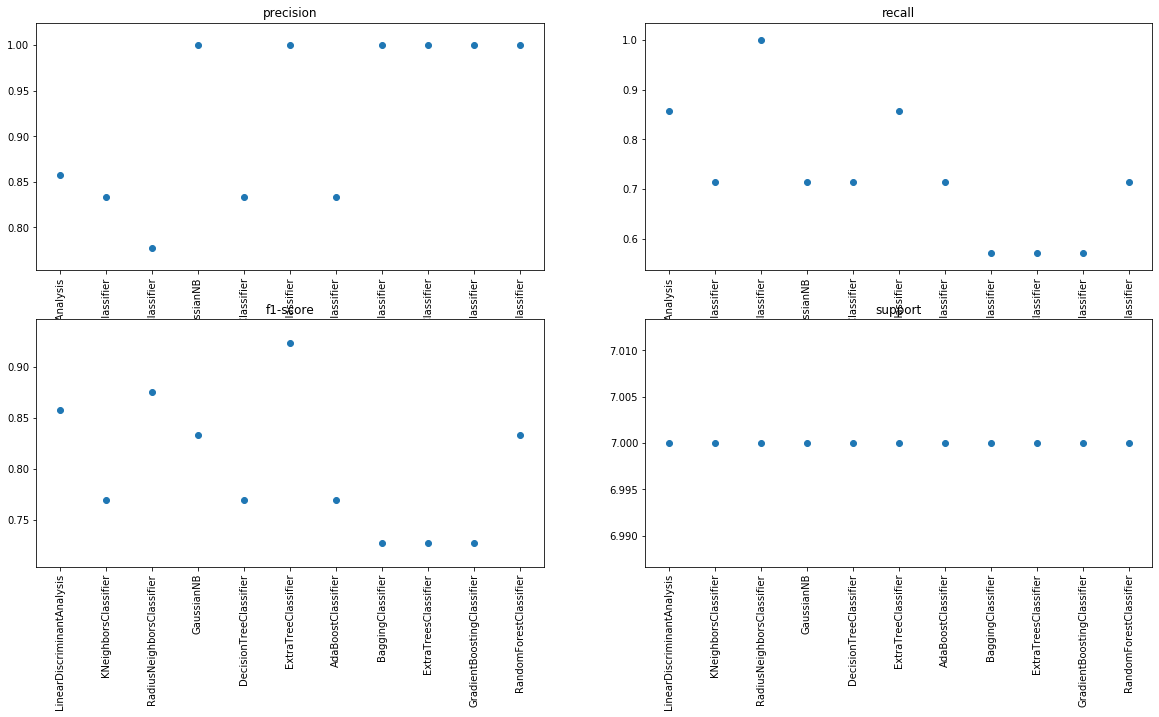

In [15]:
fig = plt.figure()
for i, metric in enumerate(results[list(results.keys())[0]]['classification_report']['True']):
    plt.subplot(2,2,i+1)
    plt.title(metric)
    print_metric_in_cl(metric, 'True')

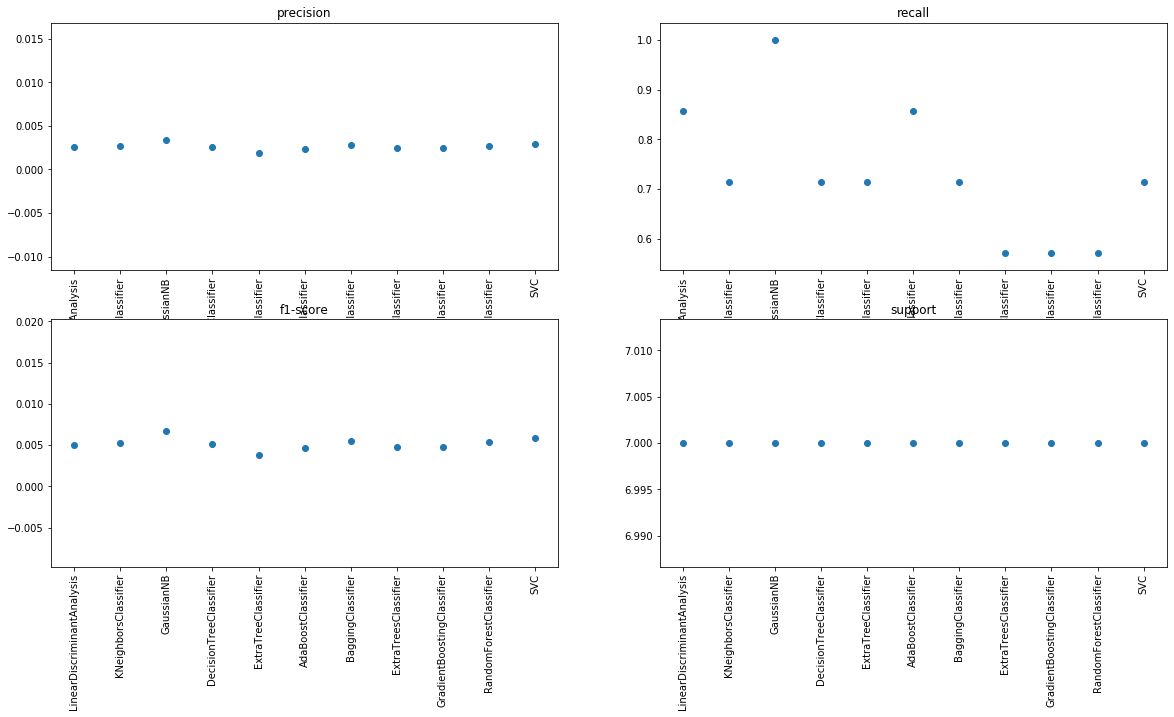

In [16]:
fig = plt.figure()
for i, metric in enumerate(results[list(results.keys())[0]]['classification_report']['True']):
    plt.subplot(2,2,i+1)
    plt.title(metric)
    print_metric_in_cl(metric, 'True', all_results)

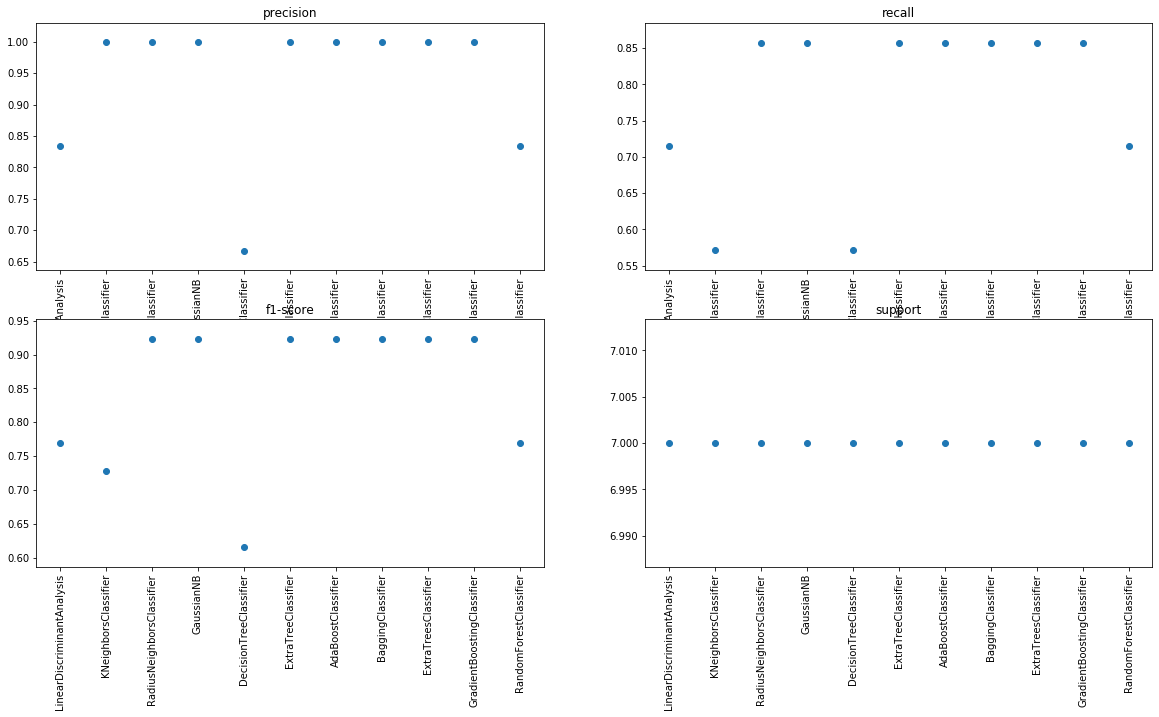

In [20]:
fig = plt.figure()
for i, metric in enumerate(results[list(results.keys())[0]]['classification_report']['False']):
    plt.subplot(2,2,i+1)
    plt.title(metric)
    print_metric_in_cl(metric, 'False')

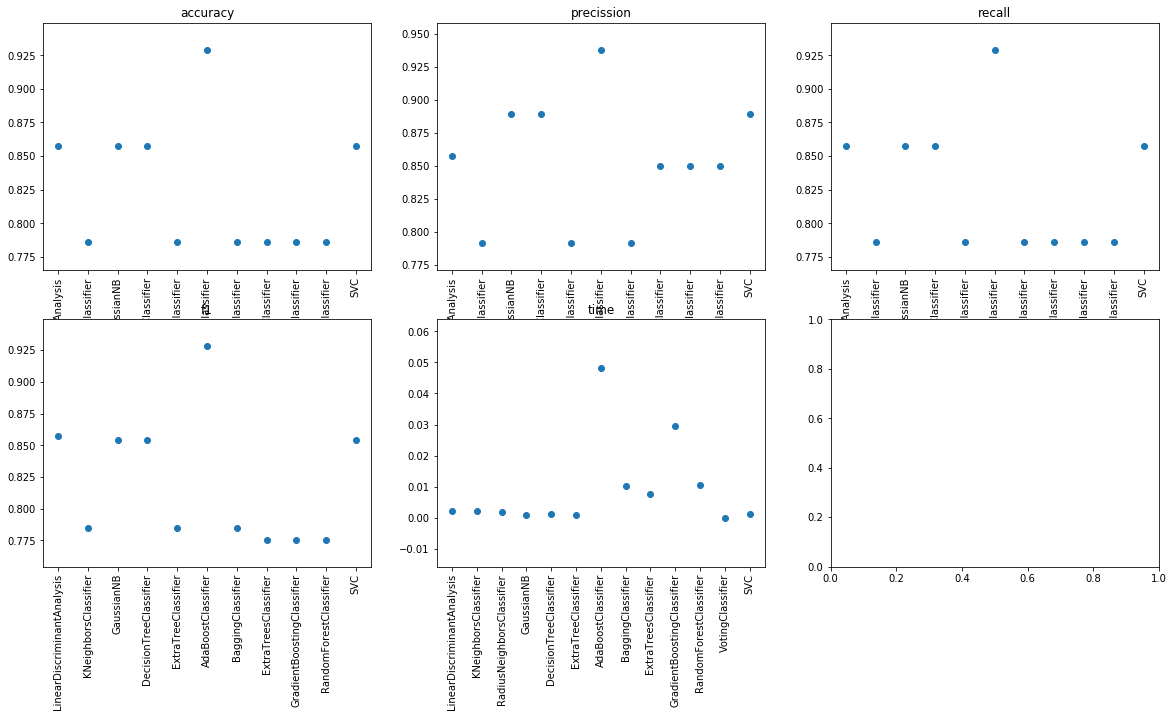

In [17]:
fig = plt.figure()
for i, metric in enumerate(results[list(results.keys())[0]]):
    plt.subplot(2,3,i+1)
    if metric != 'classification_report':
        plt.title(metric)
        print_metric(metric)

In [15]:
max([r['accuracy'] for _, r in results.items() if 'accuracy' in r]),\
max([r['precission'] for _, r in results.items() if 'precission' in r]),\
max([r['recall'] for _, r in results.items() if 'recall' in r]),\

(0.9285714285714286, 0.9375, 0.9285714285714286)

## Per Class Metrics: Belonging to Candidate or Spread

In [25]:
max([r['classification_report']['True']['precision'] for _, r in results.items() if 'False' in r['classification_report']]),\
max([r['classification_report']['True']['recall'] for _, r in results.items() if 'False'  in r['classification_report']]),\
max([r['classification_report']['True']['f1-score'] for _, r in results.items() if 'False'  in r['classification_report']]),\

(1.0, 1.0, 0.923076923076923)

In [26]:
max([r['classification_report']['True']['precision'] for _, r in all_results.items() if 'False' in r['classification_report']]),\
max([r['classification_report']['True']['recall'] for _, r in all_results.items() if 'False'  in r['classification_report']]),\
max([r['classification_report']['True']['f1-score'] for _, r in all_results.items() if 'False'  in r['classification_report']]),\

(0.004243281471004243, 1.0, 0.008444757213230118)

## Per Class Metrics: Not belonging to Candidate or Spread

In [19]:
max([r['classification_report']['False']['precision'] for _, r in results.items() if 'False' in r['classification_report']]),\
max([r['classification_report']['False']['recall'] for _, r in results.items() if 'False'  in r['classification_report']]),\
max([r['classification_report']['False']['f1-score'] for _, r in results.items() if 'False'  in r['classification_report']]),\

(1.0, 1.0, 0.9333333333333333)